<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#NeuralNetRegressor" data-toc-modified-id="NeuralNetRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>NeuralNetRegressor</a></span><ul class="toc-item"><li><span><a href="#net_1-dropout" data-toc-modified-id="net_1-dropout-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>net_1 dropout</a></span></li><li><span><a href="#net_2-dropout" data-toc-modified-id="net_2-dropout-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>net_2 dropout</a></span></li></ul></li></ul></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span><strong>Общий вывод</strong></a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

<div style="border:solid Chocolate 2px; padding: 40px">

## Описание проекта

Сервис такси подготовил исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.
    
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<b>Описание данных</b>  

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [11]:
import pandas as pd
import numpy as np
from numpy.random import RandomState

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error

from catboost import Pool, CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from skorch import NeuralNetRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import shap

import warnings

import time

RANDOM_STATE = 42

In [12]:
warnings.filterwarnings("ignore")

In [13]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [14]:
data.sort_index(inplace=True)

In [15]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [16]:
data = data.resample('1H').sum()

In [17]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

## Анализ

Необходимо проверить, в хронологическом ли порядке расположены даты и время.

In [18]:
print(data.index.is_monotonic)

True


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [20]:
data.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

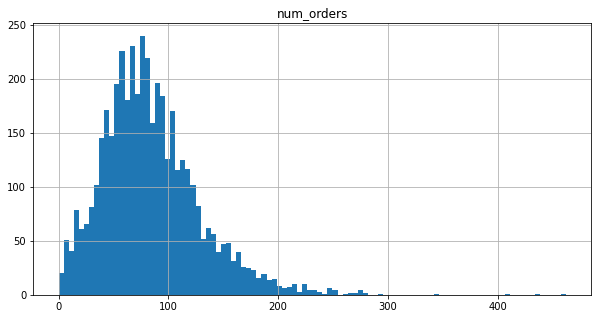

In [21]:
data.hist(bins=100, figsize=(10, 5));

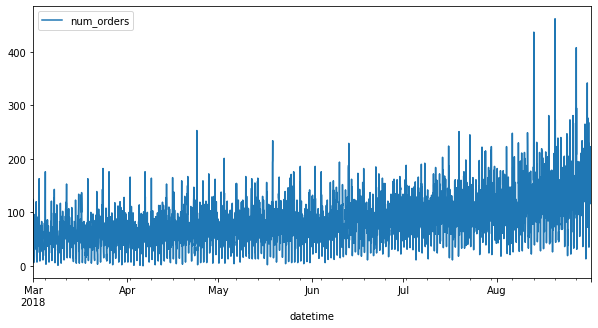

In [22]:
data.plot(figsize=(10, 5));

In [23]:
print(data.index.min(), data.index.max())

2018-03-01 00:00:00 2018-08-31 23:00:00


In [24]:
decomposed = seasonal_decompose(data)

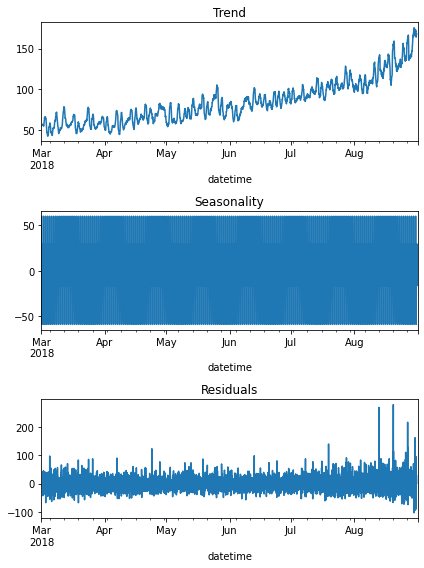

In [25]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [26]:
decomposed.seasonal['2018-03-01':'2018-04-01']

datetime
2018-03-01 00:00:00    60.248112
2018-03-01 01:00:00    20.177074
2018-03-01 02:00:00    28.982743
2018-03-01 03:00:00    17.885407
2018-03-01 04:00:00     2.791145
                         ...    
2018-04-01 19:00:00    -7.124270
2018-04-01 20:00:00    -2.696560
2018-04-01 21:00:00    10.670243
2018-04-01 22:00:00    13.596814
2018-04-01 23:00:00    25.000503
Freq: H, Name: seasonal, Length: 768, dtype: float64

Text(0.5, 1.0, 'Seasonality')

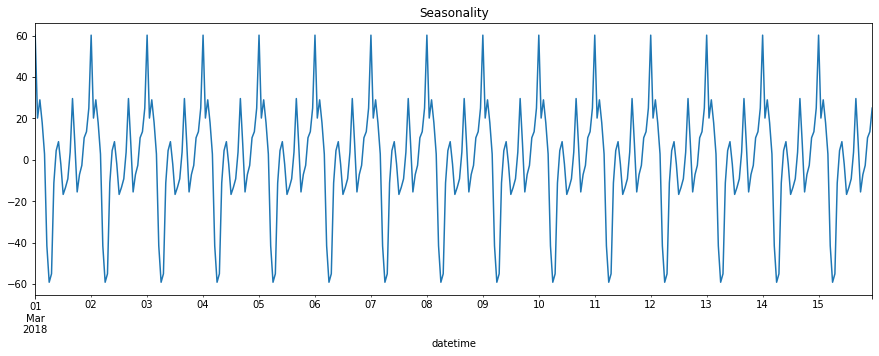

In [27]:
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

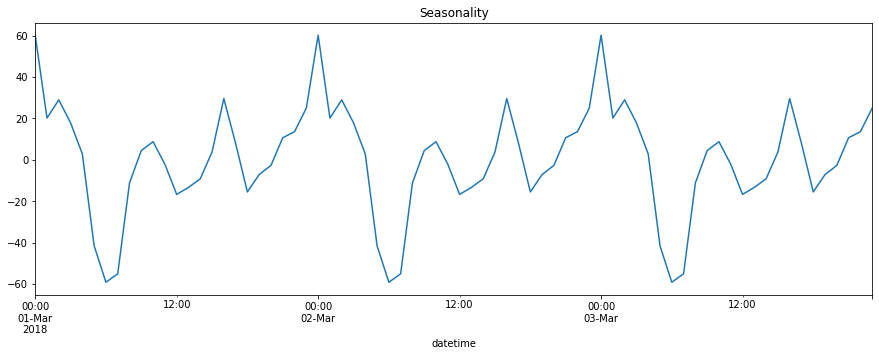

In [28]:
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')

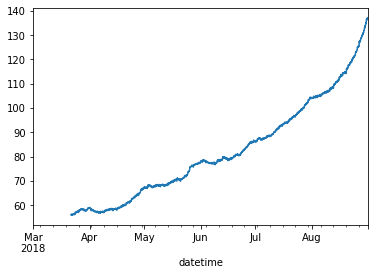

In [29]:
dt = data.copy()
dt['rolling_mean'] = dt.rolling(500).mean()
dt['rolling_mean'].plot();

In [30]:
dt.head()

num_orders  rolling_mean
datetime                                     
2018-03-01 00:00:00         124           NaN
2018-03-01 01:00:00          85           NaN
2018-03-01 02:00:00          71           NaN
2018-03-01 03:00:00          66           NaN
2018-03-01 04:00:00          43           NaN

**Вывод**

Файл содержит данные о количестве заказов такси с марта по август 2018 года. Данные распределены нормально.
Мы ресеплировали данные выбрав новую длину интервала в 1 час, количество заказов соответсвенно суммировали.
Можно заметить тренд по увеличению количества заказов летом. Также хорошо видны "сезонные" колебания в течении суток.

### Подготовка данных

Напишем функцию для создания признаков. Добавим такие признаки как месяц, день и день недели. Для прогнозирования роста или уменьшения заказов добавим "отстающие значения". Также определим скользящее среднее, чтобы выявить общий тренд временного ряда.
Определим наибольшее количество отставаний и размер окна для скользящего среднего при помощи простой линейной регрессии.

In [31]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [32]:
best_score = 100
best_model = None
best_max_lag = 0
best_rolling_mean_size = 0
best_rmse = 0

for max_lag in [1, 2, 5, 10, 20, 40, 80]:
    for rolling_mean_size in [5, 10, 20, 40, 100, 500, 1000, 2000]:
        
        df = make_features(data, max_lag, rolling_mean_size)

        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()

        target_train = train['num_orders']
        features_train = train.drop('num_orders', axis=1)

        target_test = test['num_orders']
        features_test = test.drop('num_orders', axis=1)
        
        tscv = TimeSeriesSplit(n_splits=3)
        model = LinearRegression(fit_intercept=False)
        model.fit(features_train, target_train)
        scores = cross_val_score(estimator=model, cv=tscv, X=features_train, y=target_train,
                                 scoring='neg_root_mean_squared_error')
        cv_score = -np.average(scores)
        
        predictions = model.predict(features_test)
        rmse = mean_squared_error(target_test, predictions, squared=False)
        
        #print('max_lag:', max_lag, 'rolling_mean_size', rolling_mean_size, 'cv_score:', cv_score, 'rmse:', rmse)
        
        if cv_score < best_score:
            best_score = cv_score
            best_model = model
            best_rmse = rmse
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size

print('best_max_lag:', best_max_lag, 'best_rolling_mean_size:', best_rolling_mean_size, 'best_score:', best_score, 'best_rmse:', best_rmse)

data = make_features(data, best_max_lag, best_rolling_mean_size)
data.head()

best_max_lag: 80 best_rolling_mean_size: 10 best_score: 24.516363037251647 best_rmse: 41.78402177098253


num_orders  month  day  dayofweek  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-01 00:00:00         124      3    1          3    NaN    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3  124.0    NaN    NaN   
2018-03-01 02:00:00          71      3    1          3   85.0  124.0    NaN   
2018-03-01 03:00:00          66      3    1          3   71.0   85.0  124.0   
2018-03-01 04:00:00          43      3    1          3   66.0   71.0   85.0   

                     lag_4  lag_5  lag_6  ...  lag_72  lag_73  lag_74  lag_75  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 04:00:00  124.0    NaN    NaN  ...     NaN     NaN     NaN     NaN   

                     lag_76  lag_77  lag_78  lag_79  lag_80  rolling_mean  
datetime                                                                   
2018-03-01 00:00:00     NaN     NaN     NaN     NaN     NaN           NaN  
2018-03-01 01:00:00     NaN     NaN     NaN     NaN     NaN           NaN  
2018-03-01 02:00:00     NaN     NaN     NaN     NaN     NaN           NaN  
2018-03-01 03:00:00     NaN     NaN     NaN     NaN     NaN           NaN  
2018-03-01 04:00:00     NaN     NaN     NaN     NaN     NaN           NaN  

[5 rows x 85 columns]

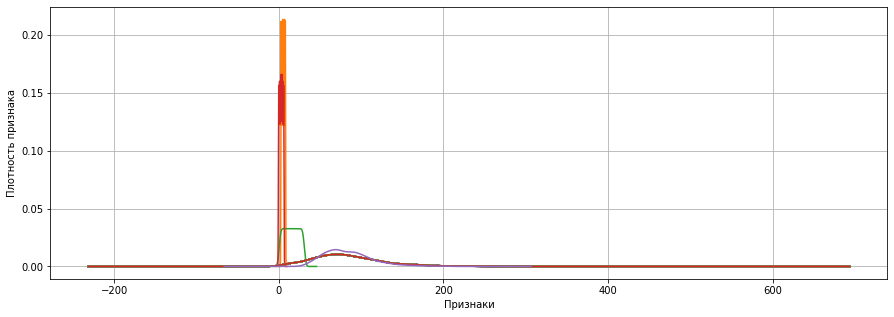

In [33]:
data.plot(kind='density', figsize=(15, 5), grid=True, legend=False)
plt.xlabel('Признаки')
plt.ylabel('Плотность признака');

Данные не требуют масштабирования.

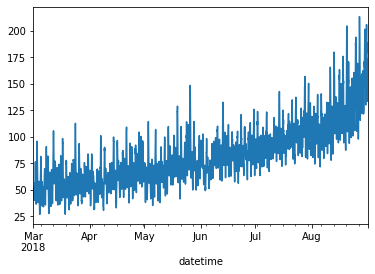

In [34]:
data['rolling_mean'].plot();

In [35]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [36]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

features_train.shape, target_train.shape

((3894, 84), (3894,))

In [37]:
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

features_test.shape, target_test.shape

((442, 84), (442,))

In [38]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-04 08:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


**Вывод**

Мы написали функцию для создания признаков. Добавили такие признаки как месяц, день и день недели. Для прогнозирования роста или уменьшения заказов добавили "отстающие значения". Определили скользящее среднее, чтобы выявить общий тренд временного ряда.

## Обучение

### LinearRegression

In [39]:
# Оценим качество работы линейной регрессии при помощи кросс-валидации.
# Для этого создадим объект-генератор разбиений для временного ряда при помощи TimeSeriesSplit.
# Число фолдов зададим равным 5.

tscv = TimeSeriesSplit(n_splits=5)

In [40]:
model_LR = LinearRegression()

In [41]:
model_params = {"fit_intercept": [True, False],
                "copy_X": [True, False]}

gs_LR = GridSearchCV(model_LR, model_params, cv=tscv, scoring='neg_root_mean_squared_error')

In [42]:
%%time
start_time = time.time()  # время начала выполнения

gs_LR.fit(features_train, target_train)

end_time = time.time()  # время окончания выполнения
execution_time_LR = end_time - start_time  # вычисляем время выполнения
print(f"Время выполнения программы: {execution_time_LR} секунд")

Время выполнения программы: 4.546790838241577 секунд
CPU times: user 1.84 s, sys: 2.74 s, total: 4.58 s
Wall time: 4.55 s


In [43]:
gs_LR.best_params_

{'copy_X': True, 'fit_intercept': False}

In [44]:
LR_best_score = -gs_LR.best_score_
LR_best_score

24.251716442106858

In [45]:
predictions_LR = gs_LR.best_estimator_.predict(features_test)
rmse_LR = mean_squared_error(target_test, predictions_LR, squared=False)
rmse_LR

41.78402177098253

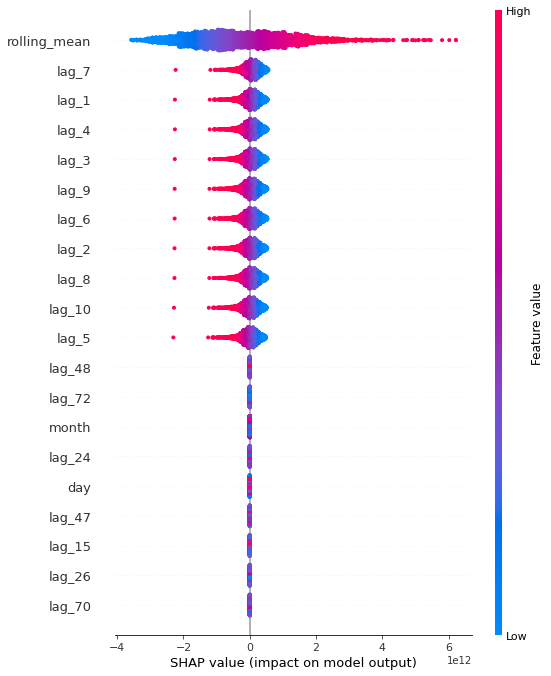

In [46]:
explainer = shap.Explainer(gs_LR.best_estimator_, features_train)
shap_values = explainer.shap_values(features_train)

shap.summary_plot(shap_values, features_train, feature_names=features_train.columns)

### RandomForestRegressor

In [47]:
tscv = TimeSeriesSplit(n_splits=5)

In [48]:
model_forest = RandomForestRegressor()

model_params = {'n_estimators': range (1, 6, 2),
                'max_depth': range (1, 13, 2),
                'min_samples_leaf': range (1,8)}

grid_forest = GridSearchCV(model_forest, model_params, cv=tscv, scoring='neg_root_mean_squared_error')

In [49]:
%%time
start_time = time.time()  # время начала выполнения

grid_forest.fit(features_train, target_train)

end_time = time.time()  # время окончания выполнения
execution_time_RF = end_time - start_time  # вычисляем время выполнения
print(f"Время выполнения программы: {execution_time_RF} секунд")

Время выполнения программы: 60.01824426651001 секунд
CPU times: user 59.4 s, sys: 567 ms, total: 60 s
Wall time: 1min


In [50]:
grid_forest.best_params_

{'max_depth': 11, 'min_samples_leaf': 7, 'n_estimators': 5}

In [51]:
RF_best_score = -grid_forest.best_score_
RF_best_score

25.567178229915555

In [52]:
predictions_forest = grid_forest.best_estimator_.predict(features_test)

In [53]:
rmse_forest = mean_squared_error(target_test, predictions_forest, squared=False)
rmse_forest

42.16044465093467

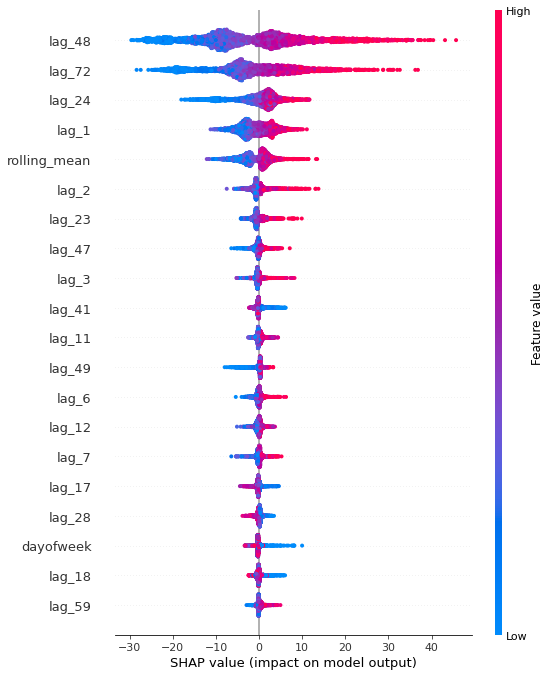

In [55]:
explainer = shap.Explainer(grid_forest.best_estimator_, features_train)
shap_values = explainer.shap_values(features_train)

shap.summary_plot(shap_values, features_train, feature_names=features_train.columns)

### Catboost

In [56]:
train_data = features_train
train_label = target_train
test_data = features_test

In [57]:
train_pool = Pool(train_data, 
                  train_label)
test_pool = Pool(test_data) 

In [58]:
model_cat = CatBoostRegressor()

params = {'learning_rate': [0.03, 0.1],
        'depth': [6, 10],
        'l2_leaf_reg': [1, 5, 9]}

grid_cat = GridSearchCV(model_cat, params, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error')

In [59]:
%%time
start_time = time.time()  # время начала выполнения

grid_cat.fit(train_data, train_label)

end_time = time.time()  # время окончания выполнения
execution_time_cat = end_time - start_time  # вычисляем время выполнения
print(f"Время выполнения программы: {execution_time_cat} секунд")

0:	learn: 29.0470906	total: 60.4ms	remaining: 1m
1:	learn: 28.6529088	total: 69.1ms	remaining: 34.5s
2:	learn: 28.2603305	total: 77.2ms	remaining: 25.6s
3:	learn: 27.8478815	total: 85.2ms	remaining: 21.2s
4:	learn: 27.5033281	total: 94.2ms	remaining: 18.8s
5:	learn: 27.1534259	total: 103ms	remaining: 17.1s
6:	learn: 26.8272303	total: 112ms	remaining: 15.9s
7:	learn: 26.4950067	total: 121ms	remaining: 15s
8:	learn: 26.1526435	total: 130ms	remaining: 14.3s
9:	learn: 25.8464530	total: 139ms	remaining: 13.8s
10:	learn: 25.4943386	total: 148ms	remaining: 13.3s
11:	learn: 25.1716391	total: 158ms	remaining: 13s
12:	learn: 24.8646647	total: 167ms	remaining: 12.7s
13:	learn: 24.5545920	total: 177ms	remaining: 12.4s
14:	learn: 24.2784940	total: 186ms	remaining: 12.2s
15:	learn: 24.0063238	total: 194ms	remaining: 11.9s
16:	learn: 23.7834247	total: 203ms	remaining: 11.8s
17:	learn: 23.5251419	total: 212ms	remaining: 11.6s
18:	learn: 23.2542228	total: 221ms	remaining: 11.4s
19:	learn: 23.0269647	to

In [60]:
grid_cat.best_params_

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [61]:
cat_best_score = -grid_cat.best_score_
cat_best_score

23.288619885020914

In [63]:
predictions_cat = grid_cat.best_estimator_.predict(test_pool)

In [64]:
rmse_cat = mean_squared_error(target_test, predictions_cat, squared=False)
rmse_cat

37.643854187571755

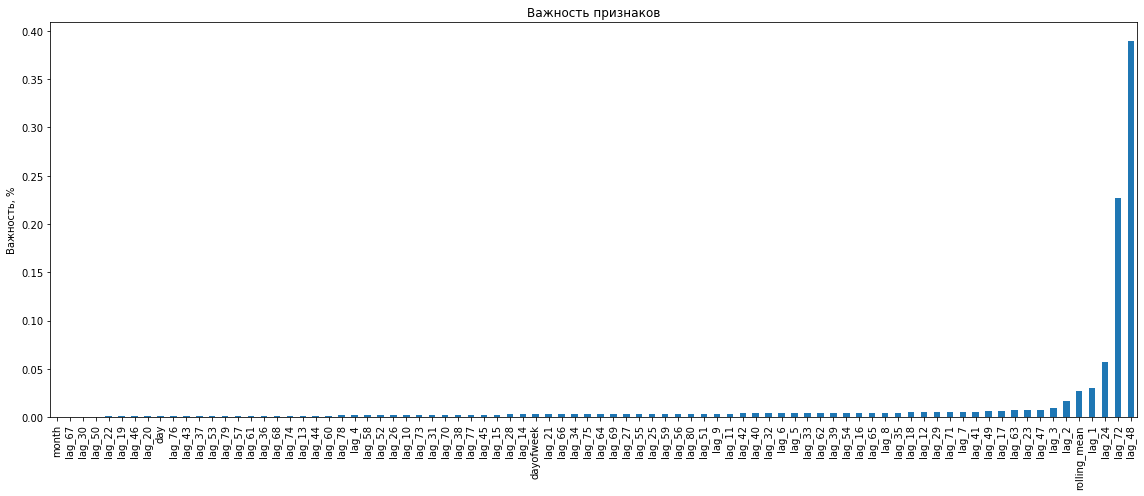

In [65]:
importances = pd.Series(grid_forest.best_estimator_.feature_importances_,
                         features_train.columns).sort_values()
fig, ax = plt.subplots(figsize=(16,7))
importances.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

### NeuralNetRegressor

#### net_1 dropout

In [67]:
tscv = TimeSeriesSplit(n_splits=5)

In [68]:
# Преобразование в тензоры PyTorch
X_train = torch.FloatTensor(features_train.values)
X_test = torch.FloatTensor(features_test.values)
y_train = torch.FloatTensor(target_train.values).reshape(-1, 1)
y_test = torch.FloatTensor(target_test.values).reshape(-1, 1)

In [69]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3894, 84]),
 torch.Size([442, 84]),
 torch.Size([3894, 1]),
 torch.Size([442, 1]))

In [70]:
# PyTorch classifier
class NetRegressor(nn.Module):
    def __init__(self, activation=nn.ReLU, n_neurons=10, dropout_rate=0):
        super().__init__()
        self.layer = nn.Linear(X_train.size()[1], n_neurons)
        self.act = activation()
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(n_neurons, 1)
        self.prob = nn.ReLU()
 
    def forward(self, x):
        x = self.act(self.layer(x))
        x = self.dropout(x)
        x = self.prob(self.output(x))
        return x

In [71]:
# create model with skorch
model_net = NeuralNetRegressor(
    NetRegressor,
    criterion=nn.MSELoss(),
    optimizer=optim.Adam,
    verbose=False
)

In [72]:
param_grid = {
    'max_epochs': [10, 15],
    'module__activation': [nn.ReLU, nn.LeakyReLU, nn.ELU],
    'optimizer__lr': [3e-1, 2e-2, 1e-3],
    'module__n_neurons': [30, 50],
    'module__dropout_rate': [0, 0.2]
}

grid = GridSearchCV(estimator=model_net, param_grid=param_grid, n_jobs=-1, cv=tscv, scoring='neg_root_mean_squared_error')

In [73]:
%%time
start_time = time.time()  # время начала выполнения

grid_result = grid.fit(X_train, y_train)

end_time = time.time()  # время окончания выполнения
execution_time_net = end_time - start_time  # вычисляем время выполнения
print(f"Время выполнения программы: {execution_time_net} секунд")

Время выполнения программы: 500.7673695087433 секунд
CPU times: user 8min 19s, sys: 762 ms, total: 8min 20s
Wall time: 8min 20s


In [74]:
grid_result.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=NetRegressor(
    (layer): Linear(in_features=84, out_features=50, bias=True)
    (act): ELU(alpha=1.0)
    (dropout): Dropout(p=0, inplace=False)
    (output): Linear(in_features=50, out_features=1, bias=True)
    (prob): ReLU()
  ),
)

In [75]:
grid_result.best_params_

{'max_epochs': 15,
 'module__activation': torch.nn.modules.activation.ELU,
 'module__dropout_rate': 0,
 'module__n_neurons': 50,
 'optimizer__lr': 0.001}

In [76]:
net_best_score = -grid_result.best_score_
net_best_score

24.74637680053711

In [77]:
predictions_net =  grid_result.best_estimator_.predict(X_test)

In [78]:
rmse_net = mean_squared_error(y_test, predictions_net, squared=False)
rmse_net

39.795795

In [79]:
# explainer = shap.Explainer(grid_result.best_estimator_.module_, features_train.to_numpy(dtype=np.float32))

explainer = shap.DeepExplainer(grid_result.best_estimator_.module_, X_train)

In [80]:
%%time
shap_values = explainer.shap_values(X_train)

CPU times: user 9min 59s, sys: 5.46 s, total: 10min 5s
Wall time: 10min 6s


#### net_2 dropout

In [82]:
tscv = TimeSeriesSplit(n_splits=5)

In [83]:
# Преобразование в тензоры PyTorch
X_train = torch.FloatTensor(features_train.values)
X_test = torch.FloatTensor(features_test.values)
y_train = torch.FloatTensor(target_train.values).reshape(-1, 1)
y_test = torch.FloatTensor(target_test.values).reshape(-1, 1)

In [84]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3894, 84]),
 torch.Size([442, 84]),
 torch.Size([3894, 1]),
 torch.Size([442, 1]))

In [85]:
# PyTorch classifier
class NetRegressor(nn.Module):
    def __init__(self, activation1=nn.ReLU, n_neurons1=10, dropout_rate1=0,
                 activation2=nn.ReLU, n_neurons2=10, dropout_rate2=0):
        super().__init__()
        self.layer1 = nn.Linear(X_train.size()[1], n_neurons1)
        self.act1 = activation1()
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.layer2 = nn.Linear(n_neurons1, n_neurons2)
        self.act2 = activation2()
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.output = nn.Linear(n_neurons2, 1)
        self.prob = nn.ReLU()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.prob(self.output(x))
        return x

In [86]:
# create model with skorch
model_net = NeuralNetRegressor(
    NetRegressor,
    criterion=nn.MSELoss(),
    optimizer=optim.Adam,
    verbose=False
)

In [87]:
param_grid = {
    'max_epochs': [10, 15],
    'module__activation1': [nn.ReLU, nn.ELU],
    'module__activation2': [nn.ReLU, nn.ELU],
    'optimizer__lr': [3e-1, 2e-2, 1e-3],
    'module__n_neurons1': [30, 50],
    'module__n_neurons2': [30, 50],
    'module__dropout_rate1': [0, 0.2, 0.4],
    'module__dropout_rate2': [0, 0.2]
}

grid = GridSearchCV(estimator=model_net, param_grid=param_grid, n_jobs=-1, cv=tscv, scoring='neg_root_mean_squared_error')

In [88]:
%%time
start_time = time.time()  # время начала выполнения

grid_result = grid.fit(X_train, y_train)

end_time = time.time()  # время окончания выполнения
execution_time_net = end_time - start_time  # вычисляем время выполнения
print(f"Время выполнения программы: {execution_time_net} секунд")

Время выполнения программы: 4778.134792089462 секунд
CPU times: user 1h 19min 27s, sys: 9.47 s, total: 1h 19min 36s
Wall time: 1h 19min 38s


In [89]:
grid_result.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=NetRegressor(
    (layer1): Linear(in_features=84, out_features=30, bias=True)
    (act1): ReLU()
    (dropout1): Dropout(p=0, inplace=False)
    (layer2): Linear(in_features=30, out_features=30, bias=True)
    (act2): ELU(alpha=1.0)
    (dropout2): Dropout(p=0.2, inplace=False)
    (output): Linear(in_features=30, out_features=1, bias=True)
    (prob): ReLU()
  ),
)

In [90]:
grid_result.best_params_

{'max_epochs': 15,
 'module__activation1': torch.nn.modules.activation.ReLU,
 'module__activation2': torch.nn.modules.activation.ELU,
 'module__dropout_rate1': 0,
 'module__dropout_rate2': 0.2,
 'module__n_neurons1': 30,
 'module__n_neurons2': 30,
 'optimizer__lr': 0.02}

In [91]:
net_best_score = -grid_result.best_score_
net_best_score

24.07818946838379

In [92]:
predictions_net =  grid_result.best_estimator_.predict(X_test)

In [93]:
rmse_net = mean_squared_error(y_test, predictions_net, squared=False)
rmse_net

41.357063

In [94]:
explainer = shap.DeepExplainer(grid_result.best_estimator_.module_, X_train)

In [95]:
%%time
shap_values = explainer.shap_values(X_train)

CPU times: user 10min 13s, sys: 5.09 s, total: 10min 18s
Wall time: 10min 19s


## Prophet

In [102]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [103]:
data = data.resample('1H').sum()

In [104]:
# data_pr = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])
data_pr = data.copy(deep=True)
data_pr.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

In [105]:
data_pr['date'] = data_pr.index

In [106]:
data_pr.reset_index(drop=True, inplace=True)

In [107]:
data_pr.head()

num_orders                date
0         124 2018-03-01 00:00:00
1          85 2018-03-01 01:00:00
2          71 2018-03-01 02:00:00
3          66 2018-03-01 03:00:00
4          43 2018-03-01 04:00:00

In [108]:
data_pr.columns = ['y','ds']
data_pr.head()

y                  ds
0  124 2018-03-01 00:00:00
1   85 2018-03-01 01:00:00
2   71 2018-03-01 02:00:00
3   66 2018-03-01 03:00:00
4   43 2018-03-01 04:00:00

In [109]:
data_pr = data_pr[['ds', 'y']]

In [110]:
print(df.iloc[:-2]) # All records except last two 
print(df.iloc[-2]) # 2nd from last record 
print(df.iloc[-2:]) # Last two records   

                     num_orders  month  day  dayofweek  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-01 00:00:00         124      3    1          3    NaN    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3  124.0    NaN    NaN   
2018-03-01 02:00:00          71      3    1          3   85.0  124.0    NaN   
2018-03-01 03:00:00          66      3    1          3   71.0   85.0  124.0   
2018-03-01 04:00:00          43      3    1          3   66.0   71.0   85.0   
...                         ...    ...  ...        ...    ...    ...    ...   
2018-08-31 17:00:00         217      8   31          4  197.0  116.0  133.0   
2018-08-31 18:00:00         207      8   31          4  217.0  197.0  116.0   
2018-08-31 19:00:00         136      8   31          4  207.0  217.0  197.0   
2018-08-31 20:00:00         154      8   31          4  136.0  207.0  217.0   
2018-08-31 21:00:00         159      8   31         

In [111]:
TEST_SIZE = int(0.1 * data_pr.shape[0])

train_data = data_pr.iloc[:-TEST_SIZE] 
test_data = data_pr.iloc[-TEST_SIZE:] 

In [112]:
train_data.shape[0]

3975

In [113]:
test_data.shape[0]

441

In [114]:
test_data.head(), test_data.index

(                      ds    y
 3975 2018-08-13 15:00:00  175
 3976 2018-08-13 16:00:00  144
 3977 2018-08-13 17:00:00  152
 3978 2018-08-13 18:00:00  104
 3979 2018-08-13 19:00:00   91,
 RangeIndex(start=3975, stop=4416, step=1))

In [115]:
test_data.tail()

ds    y
4411 2018-08-31 19:00:00  136
4412 2018-08-31 20:00:00  154
4413 2018-08-31 21:00:00  159
4414 2018-08-31 22:00:00  223
4415 2018-08-31 23:00:00  205

In [120]:
m = Prophet()
m.fit(train_data)

14:23:01 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing


In [121]:
future = m.make_future_dataframe(periods=TEST_SIZE, freq='H')
future

ds
0    2018-03-01 00:00:00
1    2018-03-01 01:00:00
2    2018-03-01 02:00:00
3    2018-03-01 03:00:00
4    2018-03-01 04:00:00
...                  ...
4411 2018-08-31 19:00:00
4412 2018-08-31 20:00:00
4413 2018-08-31 21:00:00
4414 2018-08-31 22:00:00
4415 2018-08-31 23:00:00

[4416 rows x 1 columns]

In [122]:
forecast = m.predict(future)

In [123]:
forecast.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  \
4411 2018-08-31 19:00:00  125.312384   92.592938  159.199872   124.852361   
4412 2018-08-31 20:00:00  125.335739  101.490652  164.442857   124.874048   
4413 2018-08-31 21:00:00  125.359094  117.645066  179.727657   124.895736   
4414 2018-08-31 22:00:00  125.382448  128.775434  190.574349   124.917424   
4415 2018-08-31 23:00:00  125.405803  135.636586  199.703781   124.939111   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
4411   125.803141        0.003659              0.003659              0.003659   
4412   125.828563        7.092723              7.092723              7.092723   
4413   125.854204       21.962627             21.962627             21.962627   
4414   125.880667       34.923648             34.923648             34.923648   
4415   125.907130       41.168617             41.168617             41.168617   

          daily  daily_lower  daily_upper     weekly  weekly_lower  \
4411 -11.902092   -11.902092   -11.902092  11.905752     11.905752   
4412  -4.787805    -4.787805    -4.787805  11.880528     11.880528   
4413  10.215251    10.215251    10.215251  11.747376     11.747376   
4414  23.417247    23.417247    23.417247  11.506401     11.506401   
4415  30.009602    30.009602    30.009602  11.159015     11.159015   

      weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
4411     11.905752                   0.0                         0.0   
4412     11.880528                   0.0                         0.0   
4413     11.747376                   0.0                         0.0   
4414     11.506401                   0.0                         0.0   
4415     11.159015                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
4411                         0.0  125.316043  
4412                         0.0  132.428462  
4413                         0.0  147.321720  
4414                         0.0  160.306096  
4415                         0.0  166.574420

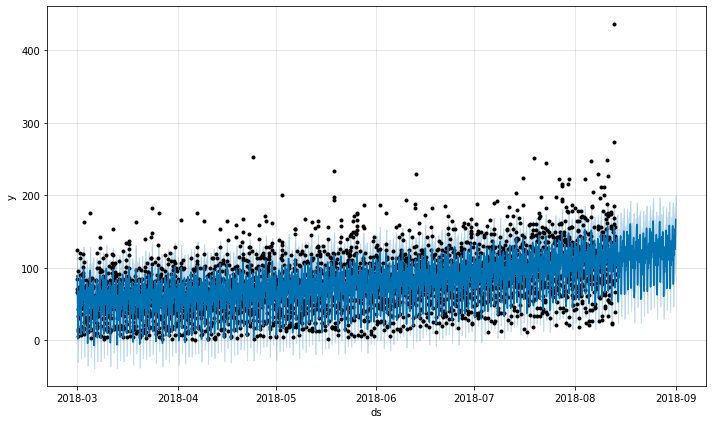

In [124]:
m.plot(
    forecast,
    ax=None,
    uncertainty=True,
    plot_cap=True,
    xlabel='ds',
    ylabel='y',
    figsize=(10, 6),
    include_legend=False,
)
plt.show()

In [125]:
prophet_pred = pd.DataFrame({"Date":forecast['ds'], 
                             "Pred":forecast["yhat"]})

prophet_pred = prophet_pred.set_index("Date")
prophet_pred[-TEST_SIZE:].tail()

Pred
Date                           
2018-08-31 19:00:00  125.316043
2018-08-31 20:00:00  132.428462
2018-08-31 21:00:00  147.321720
2018-08-31 22:00:00  160.306096
2018-08-31 23:00:00  166.574420

In [126]:
test_data = test_data.set_index(['ds'])

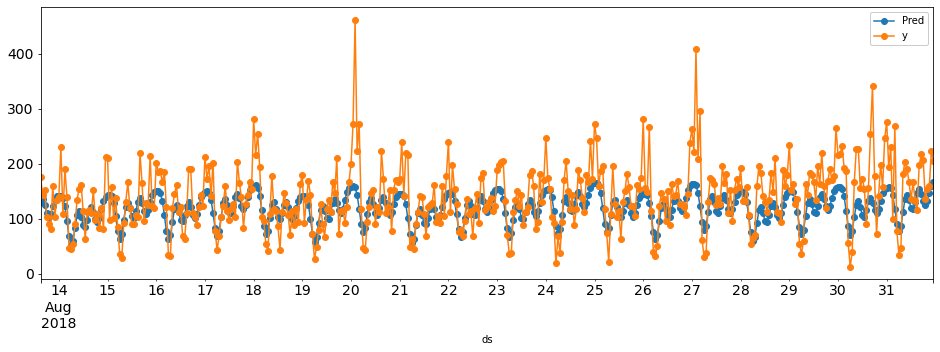

In [127]:
plt.figure(figsize=(16,5))

prophet_pred[-TEST_SIZE:]['Pred'].plot(fontsize=14, style='-o')
test_data['y'].plot(fontsize=14, style='-o')
plt.legend(loc = 'best', framealpha = 1)
plt.show()

In [153]:
prophet_rmse_error_train = rmse(test_data['y'], prophet_pred[-TEST_SIZE:]['Pred'])
prophet_mse_error_train = prophet_rmse_error_train**2
mean_value_train = test_data['y'].mean()

prophet_rmse_error_test = rmse(train_data['y'], prophet_pred[:-TEST_SIZE]['Pred'])
prophet_mse_error_test = prophet_rmse_error_test**2
mean_value_test = train_data['y'].mean()

print("Train")
print(f'MSE Error: {prophet_mse_error_train}\nRMSE Error: {prophet_rmse_error_train}\nMean: {mean_value_train}')

print("Test")
print(f'MSE Error: {prophet_mse_error_test}\nRMSE Error: {prophet_rmse_error_test}\nMean: {mean_value_test}')

Train
MSE Error: 2341.555088380905
RMSE Error: 48.38961756803731
Mean: 139.64172335600907
Test
MSE Error: 604.4738956869468
RMSE Error: 24.58605083552352
Mean: 78.2966037735849


## Тестирование

In [97]:
final_report = pd.DataFrame({'model_name': ['LinearRegression', 'Random Forest', 'Catboost', 'Neural_net'],
                            'rmse_val_score': [LR_best_score, RF_best_score, cat_best_score, net_best_score],
                            'execution_time': [execution_time_LR, execution_time_RF, execution_time_cat, execution_time_net]
                            })

In [98]:
display(final_report)

model_name  rmse_val_score  execution_time
0  LinearRegression       24.251716        4.546791
1     Random Forest       25.567178       60.018244
2          Catboost       23.288620     3520.258966
3        Neural_net       24.078189     4778.134792

**Вывод**

Мы обучили модель линейной регрессии, случайного леса, catboost и нейросеть. По результатам тестирования лучший результат показал catboost, на втором месте нейросеть и модель линейной регрессии. Стоит отметить, что обучение линейной регрессии заняло гароздо меньше времени чем обучение нейросети (почти в 100 раз быстрее) и catboost (в 700 раз быстрее). Поэтому в данной задаче целесообразно использовать модель линейной регрессии.

In [99]:
predictions_LR = gs_LR.best_estimator_.predict(features_test)
rmse_LR = mean_squared_error(target_test, predictions_LR, squared=False)
rmse_LR

41.78402177098253

In [100]:
preds = pd.DataFrame(predictions_LR, index=target_test.index)
preds.head()

0
datetime                       
2018-08-13 14:00:00  122.649414
2018-08-13 15:00:00  139.897461
2018-08-13 16:00:00  153.990234
2018-08-13 17:00:00  113.833008
2018-08-13 18:00:00   99.737305

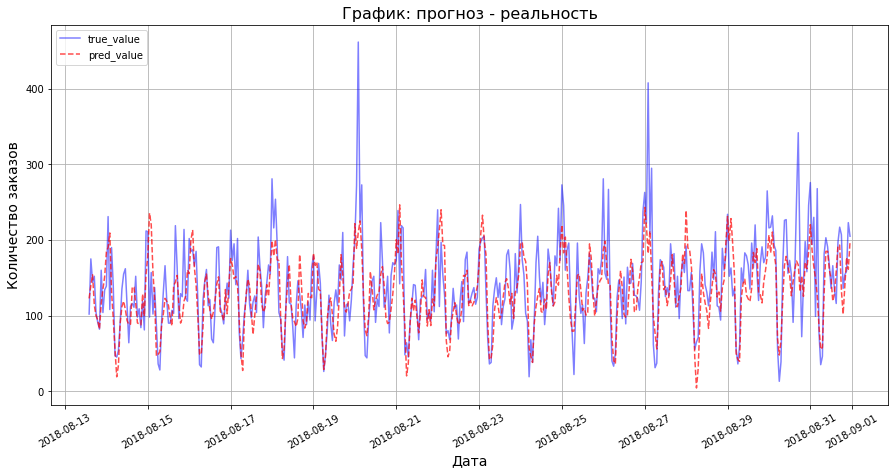

In [101]:
fig= plt.subplots(figsize=(15, 7))

plt.plot(target_test, '-', c='blue', alpha=0.5, label="true_value")
plt.plot(preds, '--', c='red', alpha=0.7, label="pred_value")
plt.title('График: прогноз - реальность', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.xticks(rotation=30)
plt.legend(loc="upper left")
plt.grid()
plt.show()

### **Общий вывод**

Мы загрузили данные о количестве заказов такси с марта по август 2018 года. Данные распределены нормально. Мы ресеплировали данные выбрав новую длину интервала в 1 час, количество заказов соответсвенно суммировали. Можно заметить тренд по увеличению количества заказов летом.

Мы написали функцию для создания признаков. Добавили такие признаки как месяц, день и день недели. Для прогнозирования роста или уменьшения заказов добавили "отстающие значения". Определили скользящее среднее, чтобы выявить общий тренд временного ряда.

Мы обучили модель линейной регрессии, случайного леса, catboost и нейросеть. По результатам тестирования лучший результат показал catboost, на втором месте нейросеть и модель линейной регрессии. Стоит отметить, что обучение линейной регрессии заняло гароздо меньше времени чем обучение нейросети (почти в 100 раз быстрее) и catboost (в 700 раз быстрее). Поэтому в данной задаче целесообразно использовать модель линейной регрессии.